# CarND Vehicle Detection Project

This is the P5 or final project for the Term #1 of Udacity Car Nano Degree. I have been enjoying all these project and this was no different. 

The goals / steps of this project are the following:

    * Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
    * Optionally, also apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
    * Normalize the features and randomize a selection for training and testing the model.
    * Implement a sliding-window technique and use trained classifier to search for vehicles in images.
    * Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    * Estimate a bounding box for vehicles detected.
    
    


## Rubric Points

Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

In [3]:
# Load all the required Modules

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import random
import pickle
#from lesson_functions import *
from sklearn import __version__ as sklearn_version

if (float(sklearn_version) >= 0.18):
    print("sklearn_version:",sklearn_version)
    from sklearn.model_selection import train_test_split
else :
    from sklearn.cross_validation import train_test_split
    
%matplotlib inline

print("Modules Successfully Loaded!!!")

sklearn_version: 0.18
Modules Successfully Loaded!!!


# Solution Design and Approach

### Visualizing the dataset

Here is an exploration of the training images provided by Udacity.

Here are links to the labeled data for 'vehicle' and 'non-vehicle' examples to train classifier. These example images come from a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself.

Vehicle Images: https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip

Non-Vehicle Images:https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

Links to GTI vehicle image database and the KITTI vision benchmark suite:
http://www.gti.ssr.upm.es/data/Vehicle_database.html
http://www.cvlibs.net/datasets/kitti/

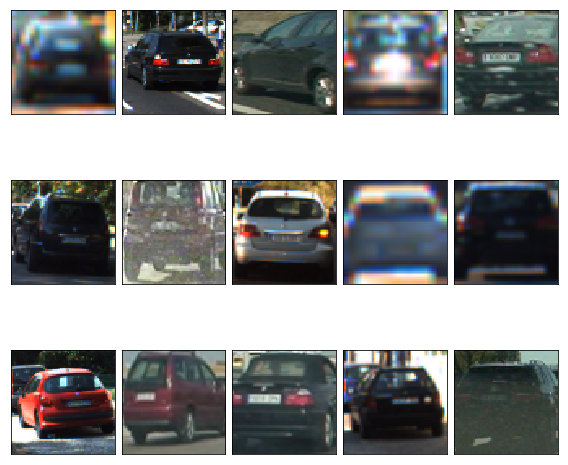

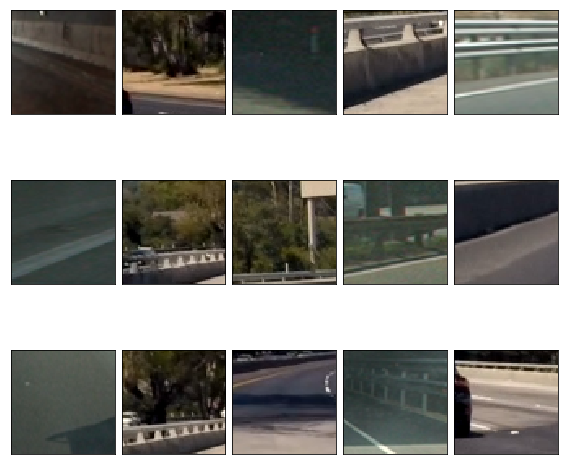

In [4]:
# Data Visualization

car_imgNames = [line.rstrip() for line in open('car.txt')]
nocar_imgNames = [line.rstrip() for line in open('notcar.txt')]

# Visualize Cars
x = random.sample(range(1, len(car_imgNames)), 15)
fig = plt.figure(figsize=(8,8))
axes = []
for i in range(0, len(x)):
    axis = fig.add_subplot(3,5,i+1)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    axis.imshow(mpimg.imread(car_imgNames[x[i]]))
    #axis.imshow(cv2.equalizeHist(cv2.imread(car_imgNames[x[i]], 0)))

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('carvisualize_color.jpg')
plt.show()


# Visualize Non-Cars
x = random.sample(range(1, len(nocar_imgNames)), 15)
fig = plt.figure(figsize=(8,8))
axes = []
for i in range(0, len(x)):
    axis = fig.add_subplot(3,5,i+1)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    axis.imshow(mpimg.imread(nocar_imgNames[x[i]]))
    #axis.imshow(cv2.equalizeHist(cv2.imread(nocar_imgNames[x[i]], 0)))

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('notcarvisualize_color.jpg')
plt.show()

Total no of Vehicle and non-Vehicle images to Train the model :

In [5]:
car_imgNames = [line.rstrip() for line in open('car.txt')]
nocar_imgNames = [line.rstrip() for line in open('notcar.txt')]

print ("cars:", len(car_imgNames))
print ("NOT cars:", len(nocar_imgNames))

cars: 8792
NOT cars: 8968


### Helper Functions:

Below are all the helper function used in this complete project

In [53]:
#### All the required Helper Functions

import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

#### Define a function to return HOG features with/without visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        #print("Defined Function - get_hog_features")
        return features


##### Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    #print("Defined Function - bin_spatial")
    return features


##### Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):   #, bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)  #, range=bins_range
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)  #, range=bins_range
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)  #, range=bins_range
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #print("Defined Function - color_hist")
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

##### Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        #print("len file_features:", len(file_features))    
        features.append(np.concatenate(file_features))
        #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    #print("Defined Function - extract_features")
    return features
    

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    #print("Defined Function - slide_window")
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    #print("Defined Function - draw_boxes")
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    #print("Defined Function - single_img_features")
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        test_img = test_img.astype(np.float32)/255
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    #print("Defined Function - search_windows")
    return on_windows


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #print("Find Cars")
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # An array to store detection boxes (Bonding Boxes)
    detections = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #print("ctrans_tosearch size:", ctrans_tosearch.shape)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
             
            test_prediction = svc.predict(test_features)
            #print("test_prediction:", test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                position = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                #print("position", position)
                
                detections.append(position)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return detections

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    #print("Defined Function - add_heat")   
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    #print("Defined Function - apply_threshold for Heatmap") 
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    #print("Defined Function - draw_labeled_bboxes")
    return img


### Data Extraction
Below is the code used to extracte the Vehicle and Non-Vehicle images from the Data set provided.

In [21]:
#### Function to Read the Vehicle and non-Vehicle Images

import os
import glob

t=time.time()

#### Locate and read the Vehicle images
basedir = 'vehicles/'

img_dirs = os.listdir(basedir)
cars = []

for img_dir in img_dirs :
    cars.extend(glob.glob(basedir+img_dir+'/*'))
    
print("Total # of Car Images Found:", len(cars))

with open("car.txt", 'w') as f:
    for i in cars :
        f.write(i+'\n')
        
        
##### Locate and read the Non-Vehicle images
basedir2 = 'non-vehicles/'

img_dirs2 = os.listdir(basedir2)
notcars = []

for img_dir2 in img_dirs2 :
    notcars.extend(glob.glob(basedir2+img_dir2+'/*'))
    
print("Total # of Non-Car Images Found:", len(notcars))

with open("notcar.txt", 'w') as f:
    for i in notcars :
        f.write(i+'\n') 

        
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Load car and non-car training Images...')



Total # of Car Images Found: 8792
Total # of Non-Car Images Found: 8968
0.06 Seconds to Load car and non-car training Images...


In [8]:
car_imgNames = [line.rstrip() for line in open('car.txt')]
nocar_imgNames = [line.rstrip() for line in open('notcar.txt')]

print ("cars:", len(car_imgNames))
print ("NOT cars:", len(nocar_imgNames))


cars: 8792
NOT cars: 8968


### Histograms of Color

We have used histograms of pixel intensity (color histograms) as one of the features. Below code shows how the color histogram for the RGB looks on a sample image

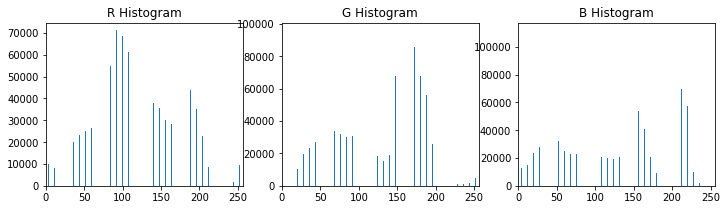

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
image = mpimg.imread('test_images/test1.jpg')



# Define a function to compute color histogram features  
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    #fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')
    

### scikit-image HOG

Now that we've got a dataset let's extract some HOG features!
http://scikit-image.org/ 
HOG Package - http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog HOG Documentation - http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

The scikit-image package has a built in function to extract Histogram of Oriented Gradient features. 

The scikit-image hog() function takes in a single color channel or grayscaled image as input, as well as various parameters. 

These parameters include orientations, pixels_per_cell and cells_per_block.

The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

The HOG features for all cells in each block are computed at each block position and the block steps across and down through the image cell by cell.

So, the actual number of features in final feature vector will be the total number of block positions multiplied by the number of cells per block, times the number of orientations, or in the case shown above: 7×7×2×2×9=1764. 

For the example above, you would call the hog() function on a single color channel img like this:
    from skimage.feature import hog
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9

    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
The visualise=True flag tells the function to output a visualization of the HOG feature computation as well, which we're calling hog_image in this case. If we take a look at a single color channel for a random car image, and its corresponding HOG visulization, they look like this:


Size of HOG: (1764,)
Size of HOG: (1764,)
Size of HOG: (1764,)
Size of HOG: (1764,)
Size of HOG: (1764,)


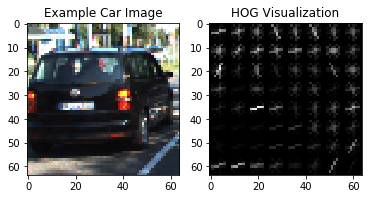

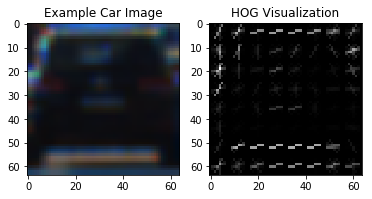

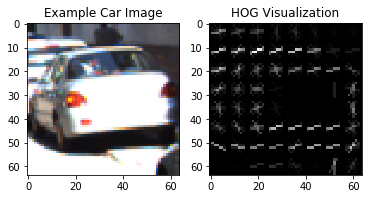

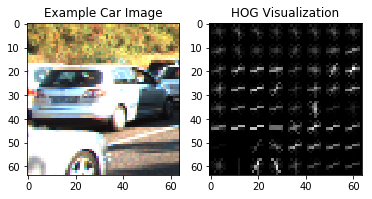

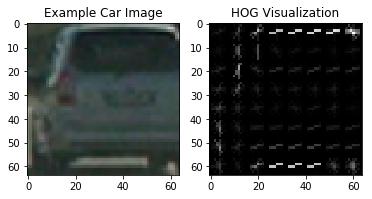

In [12]:
# Define a function to return HOG features and visualization

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog

%matplotlib inline

# Generate a random index to look at a car image
x = random.sample(range(1, len(car_imgNames)), 5)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2


for i in range(0, len(x)):
    image = mpimg.imread(car_imgNames[x[i]])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

    #print("HOG_features:",features)
    print("Size of HOG:", features.shape)

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')


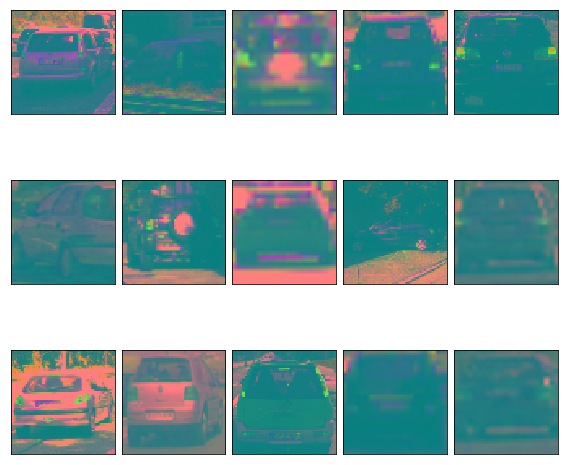

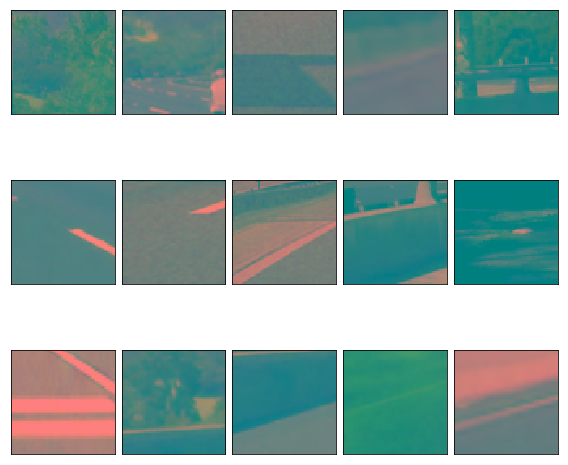

In [49]:
#Let's visualize the training set. After all the trial and error methods in lab exerices, 
#I will be using YCrCb color space for training. Hence visualizing the YCrCb here

# Visualize Cars
x = random.sample(range(1, len(car_imgNames)), 15)
fig = plt.figure(figsize=(8,8))
axes = []
for i in range(0, len(x)):
    axis = fig.add_subplot(3,5,i+1)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    #axis.imshow(mpimg.imread(car_imgNames[x[i]]))
    #axis.imshow(cv2.equalizeHist(cv2.imread(car_imgNames[x[i]], 0)))
    axis.imshow(cv2.cvtColor(mpimg.imread(car_imgNames[x[i]]), cv2.COLOR_RGB2YCrCb))

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('carvisualize.jpg')
plt.show()


# Visualize Non-Cars
x = random.sample(range(1, len(nocar_imgNames)), 15)
fig = plt.figure(figsize=(8,8))
axes = []
for i in range(0, len(x)):
    axis = fig.add_subplot(3,5,i+1)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    #axis.imshow(mpimg.imread(nocar_imgNames[x[i]]))
    #axis.imshow(cv2.equalizeHist(cv2.imread(nocar_imgNames[x[i]], 0)))
    axis.imshow(cv2.cvtColor(mpimg.imread(nocar_imgNames[x[i]]), cv2.COLOR_RGB2YCrCb))

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('notcarvisualize.jpg')
plt.show()

### Combine and Normalize Features (Color and Gradient)

Now that we have several feature extraction methods in our toolkit, We're almost ready to train a classifier, but first, as in any machine learning application we have been doing so far in all the projects, we need to normalize the data. 

Python's sklearn package provides us with the StandardScaler() method which we are going use to accomplish this task. 

To apply StandardScaler() we need to first have data in the right format, as a numpy array where each row is a single feature vector. We have created a list of feature vectors, and then convert them like this:

    import numpy as np
    feature_list = [feature_vec1, feature_vec2, ...]
    #Create an array stack, NOTE: StandardScaler() expects np.float64
    X = np.vstack(feature_list).astype(np.float64)
    
We can then fit a scaler to X, and scale it like this:

    from sklearn.preprocessing import StandardScaler
    #Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    #Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    
Now, scaled_X contains the normalized feature vectors. In the below code I am going to show how I have combined various feature extraction methods and then Normalized the data.

Your function only returns empty feature vectors...


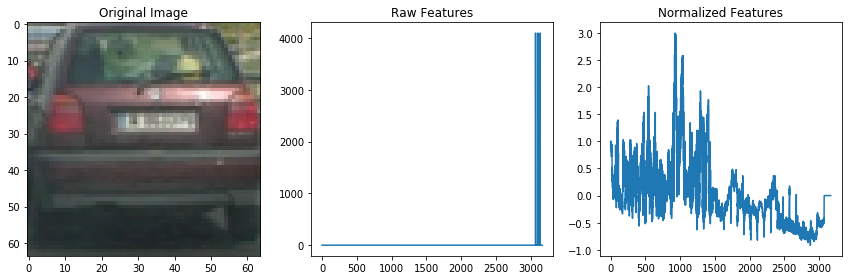

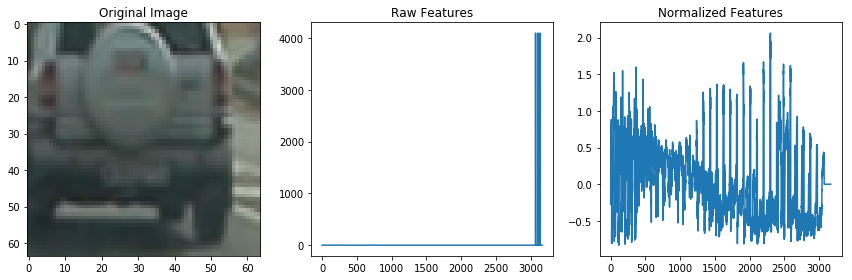

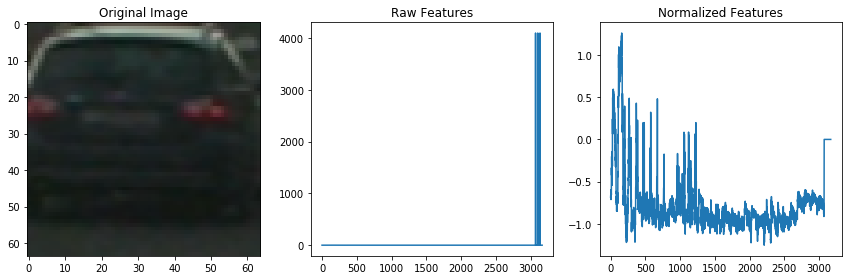

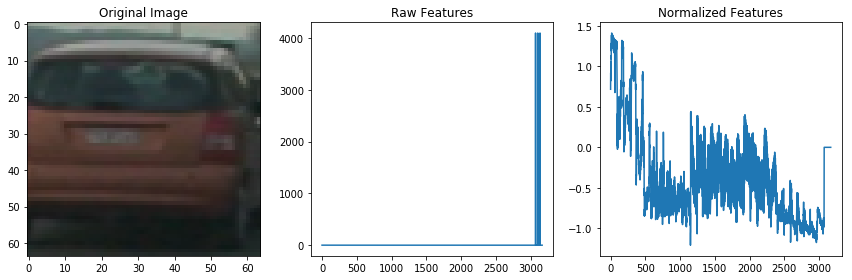

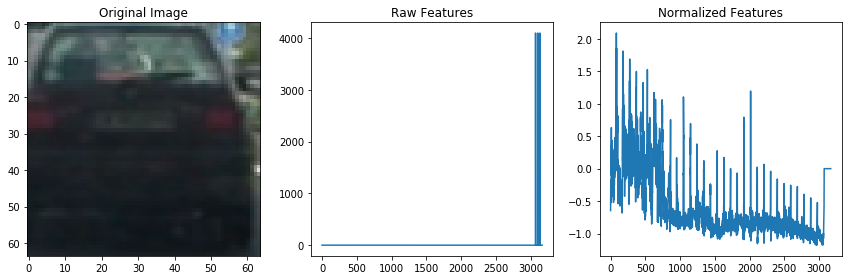

In [46]:
# Combine and Normalize Features (Color and Gradient)

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial1(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector of 1D array 
    #(as a numpy array where each row is a single feature vector)
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist1(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()


def extract_features1(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
    # Return list of feature vectors
    
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial1(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist1(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

        
car_features = extract_features1(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features1(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    #car_ind = np.random.randint(0, len(cars))
    x = random.sample(range(1, len(car_imgNames)), 5)

    for i in range(0, len(x)):
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(cars[i]))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(X[i])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[i])
        plt.title('Normalized Features')
        fig.tight_layout()
    else: 
        print('Your function only returns empty feature vectors...')

# (Linear SVC) to Train the Model

For the Final submission, I am going to use the Linear SVC Support Vector Machine Algorithm to Train the Model

Using combination of 'spatial', 'color histogram' and 'HOG' features in the same order.

In [8]:
#### Final Featuers Extraction
print("# of cars:", len(cars))
print("# of Not-Cars:",len(notcars))


#### Begine - All Hyper Parameters to Tune the Model #######
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions #16
hist_bins = 16    # Number of histogram bins, #16
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [400, 656] # Min and max in y to search in slide_window(), total of #256 pixels
y_start_stop = [None, None]
#### End of All Hyper Parameters to Tune the Model #######

t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

print("len(car_features):",len(car_features))
print("len(notcar_features):",len(notcar_features))
print("Combine len of Features:", len(X))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Extract the features of Training & Testing Images...')


# of cars: 8792
# of Not-Cars: 8968
len(car_features): 8792
len(notcar_features): 8968
Combine len of Features: 17760
128.7 Seconds to Extract the features of Training & Testing Images...


In [9]:
# Normalize and FIT to Linear SVC SVM Model (Support Vector Model)


# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC Training and Find Accuracy of Model
t=time.time()

svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
Test Accuracy of SVC =  0.9913
20.93 Seconds to train SVC...


### Save the SVC Model
Save the generated SVC Model so that we can use the same model to pridict the car dectection in Image and Video pipelines

In [10]:
print("svc",svc)

# save the model to disk
filename = 'final_SVCmodel_pickle.pkl'
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["X_scaler"] = X_scaler
pickle.dump(dist_pickle, open(filename, 'wb'))
print()
print("final_SVCmodel_pickle Saved Successfully!")

svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

final_SVCmodel_pickle Saved Successfully!


## Sliding Window Implementation

To implement a sliding window search, we need to decide what size window you want to search, where in the image we want to start and stop your search, and how much we want windows to overlap. So, below is an example to see how many windows we would be searching given a particular image size, window size, and overlap.

Suppose we have an image that is 256 x 256 pixels and we want to search windows of a size 128 x 128 pixels each with an overlap of 50% between adjacent windows in both the vertical and horizontal dimensions. Our sliding window search would then look like this:

Image Size: (720, 1280, 3)


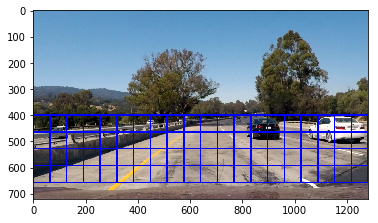

In [50]:
image = mpimg.imread('test_images/test1.jpg')

print("Image Size:", image.shape)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 656], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=3)                    
plt.imshow(window_img)



0.67 Seconds to Detect the cars in Test Image...


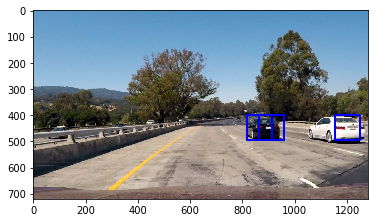

In [54]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)
t=time.time()

## Load the Saved Model from Disk
filename = 'final_SVCmodel_pickle.pkl'
dist_pickle = pickle.load(open(filename, 'rb'))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
t3 = time.time()
print(round(t3-t, 2), 'Seconds to Detect the cars in Test Image...')
plt.imshow(window_img)
plt.show()



### Hog Sub-sampling Window Search

Now lets explore a more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once. The code below defines a single function find_cars that's able to both extract features and make predictions.

The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

Below image shows how the Sub-sampling is going to work.

![title](hog-sub.jpg)

### Multiple Detections & False Positives

With all the above code and methods we are using to detect the car, one last thing we would need to take care of before we start using the code on the actual images or videos is that we need to make sure that our code is robost eough to avoid the multiple detection of same car (i.e having multiple window boxes on same car) or False Positive.

Below is one example image where we can see both multiple detections and the false positive

![title](screen-shot1.png)


To over come this, we will build a heat-map from these detections in order to combine overlapping detections and remove false positives.

To make a heat-map, we're simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by our classifier. The individual heat-maps for the above images look like this:

![title](screen-shot2.png)

Once we have a list of bounding boxes for the detections in the images. Rather than consider heat-maps for each individual image, we will add "heat" to a map for a list of bounding boxes.

    def add_heat(heatmap, bbox_list):
    #Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
    
If our classifier is working well, then the "hot" parts of the map are where the cars are, and by imposing a threshold, we will reject areas affected by false positives. Below is the snapshot of the heatmap thresholding.

    def apply_threshold(heatmap, threshold):
    #Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    #Return thresholded map
    return heatmap
    
    

Once we have a thresholded heat-map, there are many ways you could go about trying to figure out how many cars you have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the label() function from scipy.ndimage.measurements. we'll use it like this:

    from scipy.ndimage.measurements import label
    labels = label(heatmap)
    
Now labels is a 2-tuple, where the first item is an array the size of the heatmap input image and the second element is the number of labels (cars) found.

In the above series of images the same false positive window appeared twice, so if I set a threshold of 2 (meaning set all values <= 2 to 0) and then run the labels() function. I get a result that 2 cars were identified (the two islands in the heat-map) and the labeled image where pixels are set to 0 for background, 1 for car number 1, and 2 for car number 2.

    heatmap = threshold(heatmap, 2)
    labels = label(heatmap)
    print(labels[1], 'cars found')
    plt.imshow(labels[0], cmap='gray')
    
    2 cars found

![title](screen-shot3.png)


Next, we will take the labels image and put bounding boxes around the labeled regions. 
    
And the output looks like this:

![title](screen-shot4.png)

# Image/Video Processing Pipeline

In [ ]:
# Image Processing Pipeline

previous_detections = []

def process_image(image):
    
    global previous_detections
    
    ystart = 400
    ystop = 656
    scale = 1.5
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions # 16
    hist_bins = 16    # Number of histogram bins #16

    
    # Detecting vehicles using raw image data and HOG features
    vehicle_detections = find_cars(image, ystart, ystop, 
                                   scale, svc, X_scaler, 
                                   orient, pix_per_cell, cell_per_block, 
                                   spatial_size, hist_bins)
    #print("vehicle_detections", vehicle_detections)
    # Updating previous frames' detections with new frame, and removing frames that are too old
    previous_detections.append(vehicle_detections)
    previous_detections = previous_detections[-10:]
    
    #blank = np.zeros_like(image[:,:,0])
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    box_list = vehicle_detections

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    #plt.imshow(heatmap)
    #plt.show()
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap) ##### Main function for the Heatmap
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    
    # draw the text showing curvature, offset, and speed
    cv2.putText(draw_img,'# of Cars Detected = '+str(labels[1])+'car(s)',(50,50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0),2)
    
    
    # Draw the boxes on original image
    return draw_img

# Run Model on Images

# of test_images 6


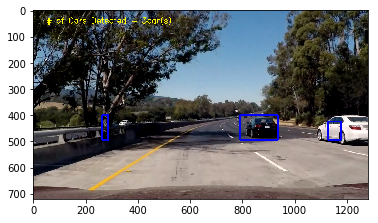

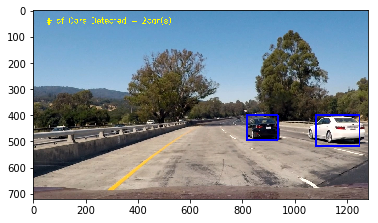

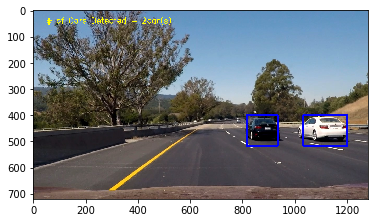

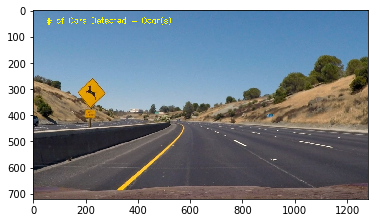

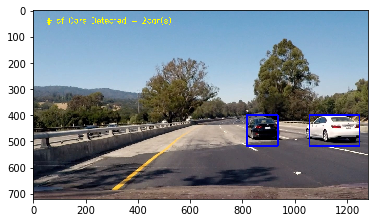

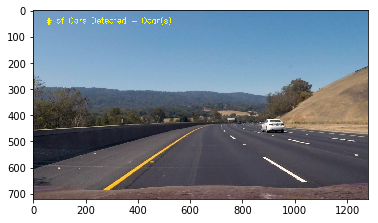

In [56]:
#### Test the Model on the TEST Images
from scipy.ndimage.measurements import label
from scipy.ndimage import minimum_position, maximum_position, center_of_mass

%matplotlib inline

## Load the Saved Model from Disk
filename = 'final_SVCmodel_pickle.pkl'
dist_pickle = pickle.load(open(filename, 'rb'))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]


# Read in test images
test_images = glob.glob('test_images/*.jpg')

print("# of test_images", len(test_images))

for testimage in test_images:
    image = mpimg.imread(testimage)
    #plt.imshow(image)
    #plt.show()
    final_img = process_image(image)
    plt.imshow(final_img)
    plt.show()
    
    

# Run Model on Video

In [19]:
# Car Detection on Video now #
from moviepy.editor import VideoFileClip
from moviepy.video.VideoClip import VideoClip
from IPython.display import HTML


## Load the Saved Model from Disk
filename = 'final_SVCmodel_pickle.pkl'
dist_pickle = pickle.load(open(filename, 'rb'))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]


Input_video = 'project_video.mp4'
#Input_video = 'test_video.mp4'
video_output = 'Output_project_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)



  self.nchannels))



[MoviePy] >>>> Building video Output_project_video.mp4
[MoviePy] Writing video Output_project_video.mp4


100%|█████████▉| 1260/1261 [10:03<00:00,  2.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_project_video.mp4 



In [20]:
#video_output = 'Output_project_video.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Files Submited

Below are the various files submitted as part of this project Submission:

Overview of the different files submitted in the project

CarND-Vehicle-Detection-P5.ipynb: Main IPython notebook with all the codes
output_images: A folder containing images throughout the project pipeline.
final_SVCmodel_pickle.pkl: Trained LinearSVC model, saved n loaded using pickle
Output_project_video.mp4: Video o/p 
CarND-Vehicle-Detection-P5-Report.ipynb: Project Report
car.txt and notcar.txt: list file


### Issues:

One of the issue that I faced was the conversion of imges when using .png VS Jpeg and .jpg.

Since for Training and Testing, we are using the images in .png form that have values for 0 to 1.
But the TEST images provided are in .JPG formate that have values from 0 to 255.

Hence I had to use the below code to convert the values of .jpg files so that they match the training image values i.e 0 to 1.

img = img.astype(np.float32)/255

I am yet to test this code on some other vidoes to analyse where this model may fail.
May be I can do this during the gap of term1 to term2.

Appricitate any suggestions or recommendation to further improve the model and make more efficient and robost.